In [1]:
# 기본 데이터 처리 라이브러리
import numpy as np
import pandas as pd

# 텍스트 전처리
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

# 모델 학습 및 평가
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

import re
from bs4 import BeautifulSoup
import html
from datetime import datetime

# 경고 무시
import warnings
import os
os.chdir('../')
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (matplotlib용)
import matplotlib.font_manager as fm
import matplotlib

font_path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'  # 폰트 경로 설정
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rcParams['font.family'] = font
matplotlib.rc('font', family=font)

# GPU 사용 가능 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Device Name : {torch.cuda.get_device_name(0) if device == "cuda" else "cpu"}")

# nltk 데이터 다운로드 (불용어 등 필요 시만 다운로드)
nltk_data = {
    "stopwords": "corpora/stopwords.zip",
    "punkt": "tokenizers/punkt.zip"
}
for key, path in nltk_data.items():
    try:
        nltk.data.find(path)
    except LookupError:
        print(f"Downloading {key}...")
        nltk.download(key)

# tqdm for progress bars
from tqdm import tqdm
tqdm.pandas()


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu
Device Name : cpu


In [2]:
DATA_PATH = './dataset_sample'
FEATURES = ['title', 'description', 'content', 'contentLength']

os.chdir('/workspaces/recommender/text_classification')

In [3]:
daangn = pd.read_csv(f'{DATA_PATH}/daangn-techblog.csv')[FEATURES]
toss = pd.read_csv(f'{DATA_PATH}/toss-techblog.csv')[FEATURES]
wooahan = pd.read_csv(f'{DATA_PATH}/wooahan-techblog.csv')[FEATURES]

daangn["from"] = "daangn"
toss["from"] = "toss"
wooahan["from"] = "wooahan"

total_article = pd.concat([daangn, toss, wooahan], axis=0)

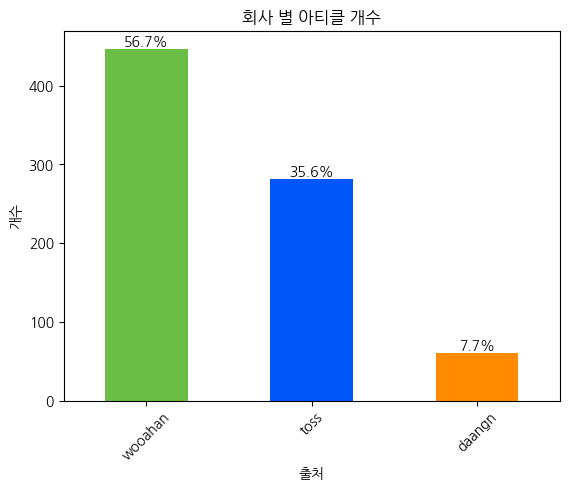

In [7]:
brand_colors = {
    'daangn': '#FF8B00',      # 당근마켓 오렌지
    'toss': '#0056F6',        # 토스 블루
    'wooahan': '#6BBE45'      # 우아한형제들 그린
}

# 데이터 준비
data = total_article['from'].value_counts()
total_count = data.sum()  # 전체 아티클 수

# 막대 그래프 생성
colors = [brand_colors[idx] for idx in data.index]
ax = data.plot(kind='bar', color=colors)

# 그래프 제목 및 레이블 설정
plt.title("회사 별 아티클 개수")
plt.xlabel("출처")
plt.ylabel("개수")
plt.xticks(rotation=45)

# 각 막대 위에 퍼센트 표시
for i, count in enumerate(data):
    percent = (count / total_count) * 100  # 퍼센트 계산
    plt.text(
        i,                     # x 좌표 (막대의 가운데)
        count + 0.5,           # y 좌표 (막대 위 약간의 여백)
        f'{percent:.1f}%',     # 퍼센트 텍스트
        ha='center',           # 수평 정렬
        va='bottom',           # 수직 정렬
        fontsize=10,           # 글꼴 크기
        color='black'          # 텍스트 색상
    )

# 그래프 표시
plt.show()

In [10]:
test = total_article.sample()

In [65]:
import re
from typing import List, Dict
from dataclasses import dataclass
from bs4 import BeautifulSoup
import html

@dataclass
class CodeBlock:
    language: str
    code: str
    line_number: int  # Starting line number in the original text
    indentation: int  # Level of indentation

class TextProcessor:
    def __init__(self, text: str):
        self.raw_text = text
        self.cleaned_text = ""
        self.code_blocks = []
        self.language_markers = {
            'python': [
                r'import\s+[\w\s,]+',
                r'def\s+\w+\s*\([^)]*\)\s*:',
                r'class\s+\w+\s*[:(]',
                r'print\s*\(',
                r'if\s+__name__\s*==\s*[\'"]__main__[\'"]',
                r'with\s+.*?\s*as\s+\w+:',
                r'try:(?:\s*except|\s*finally)',
                r'for\s+\w+\s+in\s+',
                r'while\s+.*?:'
            ],
            'javascript': [
                r'function\s+\w+\s*\([^)]*\)',
                r'const\s+\w+\s*=',
                r'let\s+\w+\s*=',
                r'var\s+\w+\s*=',
                r'import\s+.*?from',
                r'=>',
                r'console\.',
                r'module\.exports',
                r'export\s+(?:default\s+)?(?:function|class|const|let|var)'
            ],
            'java': [
                r'public\s+class',
                r'private\s+\w+',
                r'protected\s+\w+',
                r'System\.out\.',
                r'import\s+java\.',
                r'@Override'
            ],
            'sql': [
                r'SELECT\s+.*?\s+FROM',
                r'INSERT\s+INTO',
                r'UPDATE\s+.*?\s+SET',
                r'DELETE\s+FROM',
                r'CREATE\s+TABLE',
                r'ALTER\s+TABLE',
                r'DROP\s+TABLE',
                r'JOIN\s+\w+'
            ],
            'html': [
                r'<(?:html|head|body|div|span|p|a|script|link|meta)',
                r'</[a-z]+>',
                r'class=["\'].*?["\']'
            ],
            'css': [
                r'{\s*[\w-]+\s*:',
                r'@media',
                r'@import',
                r'\.[a-zA-Z][\w-]*\s*{',
                r'#[\w-]+\s*{'
            ]
        }
        self.markdown_markers = {
            'start': [
                r'```\w*',           # Code fence with optional language
                r'~~~\w*',           # Alternative code fence
                r'(?:^|\n)    ',     # Indented code block (4 spaces)
                r'(?:^|\n)\t'        # Indented code block (tab)
            ],
            'end': [
                r'```',
                r'~~~',
                r'\n\S'              # End of indentation
            ]
        }

    def detect_language(self, code: str) -> str:
        """Detect the programming language of a code block"""
        
        # Count matches for each language's patterns
        language_scores = {}
        
        for language, patterns in self.language_markers.items():
            score = 0
            for pattern in patterns:
                matches = re.finditer(pattern, code, re.IGNORECASE | re.MULTILINE)
                score += sum(1 for _ in matches)
            language_scores[language] = score
        
        # Return the language with highest score, or 'unknown' if no clear match
        max_score = max(language_scores.values())
        if max_score > 0:
            for language, score in language_scores.items():
                if score == max_score:
                    return language
        
        return 'unknown'

    def find_code_blocks(self) -> List[CodeBlock]:
        """Find all code blocks in the text"""
        code_blocks = []
        
        # First look for markdown-style code blocks
        line_number = 1
        lines = self.raw_text.split('\n')
        i = 0
        
        while i < len(lines):
            line = lines[i]
            
            # Check for code fence markers
            for start_pattern in self.markdown_markers['start']:
                if re.match(start_pattern, line):
                    code_lines = []
                    start_line = line_number
                    indentation = len(re.match(r'^\s*', line).group())
                    
                    i += 1
                    line_number += 1
                    
                    # Collect lines until end marker
                    while i < len(lines):
                        if any(re.match(end_pattern, lines[i]) for end_pattern in self.markdown_markers['end']):
                            break
                        code_lines.append(lines[i])
                        i += 1
                        line_number += 1
                    
                    if code_lines:
                        code = '\n'.join(code_lines)
                        language = self.detect_language(code)
                        code_blocks.append(CodeBlock(
                            language=language,
                            code=code,
                            line_number=start_line,
                            indentation=indentation
                        ))
            
            i += 1
            line_number += 1
        
        # Then look for language-specific patterns
        text_without_markdown = re.sub(r'```.*?```', '', self.raw_text, flags=re.DOTALL)
        for language, patterns in self.language_markers.items():
            for pattern in patterns:
                matches = re.finditer(pattern, text_without_markdown, re.MULTILINE)
                for match in matches:
                    # Get the context around the match
                    start = match.start()
                    # Find the beginning of the code block
                    block_start = text_without_markdown.rfind('\n', 0, start) + 1
                    # Find the end of the code block
                    block_end = text_without_markdown.find('\n\n', start)
                    if block_end == -1:
                        block_end = len(text_without_markdown)
                    
                    code = text_without_markdown[block_start:block_end].strip()
                    
                    # Only add if it's not already part of a detected code block
                    if not any(code in block.code for block in code_blocks):
                        line_number = text_without_markdown[:start].count('\n') + 1
                        indentation = len(re.match(r'^\s*', code).group())
                        code_blocks.append(CodeBlock(
                            language=language,
                            code=code,
                            line_number=line_number,
                            indentation=indentation
                        ))
        
        return code_blocks

    def remove_html(self):
        """Remove HTML content and decode HTML entities"""
        soup = BeautifulSoup(self.raw_text, 'html.parser')
        text = soup.get_text()
        text = html.unescape(text)
        self.cleaned_text = text

    def clean_whitespace(self):
        """Clean up excessive whitespace"""
        # Replace multiple newlines with double newline
        self.cleaned_text = re.sub(r'\n{3,}', '\n\n', self.cleaned_text)
        # Replace multiple spaces with single space
        self.cleaned_text = re.sub(r'\s{2,}', ' ', self.cleaned_text)
        # Clean up whitespace around punctuation
        self.cleaned_text = re.sub(r'\s+([.,!?])', r'\1', self.cleaned_text)

    def process_code_blocks(self):
        """Wrap detected code blocks in <code> tags"""
        for block in self.code_blocks:
            code_block_html = f'<code {block.language}>{block.code}</code>'
            self.cleaned_text = self.cleaned_text.replace(block.code, code_block_html)

    def preprocess(self) -> str:
        """Run all preprocessing steps"""
        # Remove HTML
        self.remove_html()
        
        # Detect code blocks
        self.code_blocks = self.find_code_blocks()
        
        # Process code blocks into HTML format
        self.process_code_blocks()
        
        # Clean up excessive whitespace
        self.clean_whitespace()

        return self.cleaned_text


# Example usage
def preprocess_blog_post(raw_text: str) -> str:
    """Preprocess the blog post text"""
    processor = TextProcessor(raw_text)
    processed_content = processor.preprocess()
    return processed_content


In [67]:
import pprint
pprint.pprint(preprocess_blog_post(test))

('돌아가기 <code python> Open main menu {{item.name}} 우아한스터디 우아한Tech에 문의하기 개발자 채용 '
 '파이썬으로 Linear Regression 해보기 Aug.01.2018 김세환 Data {{item.name}} {{sub.name}} '
 '들어가며\n'
 '안녕하세요. 우아한형제들 데이터서비스팀에서 섹시미 막내를 맡고 있는 김세환입니다. 데이터를 보다보면 예측모델을 만들게 되는 경우가 '
 '많은데요,\n'
 '대부분의 경우 모델을 만들기 위한 함수들이 라이브러리 형태로 구현이 되어있다보니, 이런 라이브러리를 가져다 쓰는 것이 일반적입니다. 이 '
 '때문에 모델을 만드는 데 있어 그 내용은 놓치고 지나가기 쉽습니다. 이 포스트에서는 Linear Regression(선형회귀)를 '
 '파이썬으로 직접 풀어보고 내용을 한번 되짚어보며, 데이터를 통해 어떤 식으로 값을 예측을 할 수 있을지 간단하게 알아보려고 합니다. '
 '배달시간이 얼마나 걸릴까…\n'
 '다음과 같은 데이터가 있다고 해 봅시다. # 배달거리, 배달시간 , 20min] , 24min]\n'
 ', 36min]\n'
 ', 47min]\n'
 ', 22min]\n'
 ', 32min]\n'
 ', 47min]\n'
 ', 42min]\n'
 ', 21min]\n'
 ', 21min]\n'
 ', 30min]\n'
 ', 25min]\n'
 ', 18min]\n'
 ', 38min]\n'
 ', 28min]\n'
 '각 배달건에 대해 배달거리와 배달시간을 기록해 둔 데이터인 듯 합니다.\n'
 '이 데이터를 보면 딱히 계산을 하지 않더라도,\n'
 '"200m정도 떨어진 곳에서 배달시키려고 하는데, 몇 분정도 걸릴까?" 라는 질문에\n'
 '"음… 30-40분 정도 걸릴 것 같은데?" 라고 말할 수 있을 겁니다. 아마 100미터 거리가 20분, 150미터가 24분, '
 '240미터가 32분… 과 같이 거리가 증가함에 따라 시간도 비슷한 속도로 증